# Optical Aberrations Modeling and Image Processing with Zernike Polynomials

**Questions:**

[1](#question1): Zernike Polynomial generator (10 points)

[2](#question2): Forward model (10 points)

[3](#question3): Visualizer (10 points)

[4](#question4): Problem and potential solutions (15 points)

In [16]:
import IPython
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import math
import os
import PIL
from odak.learn.tools import load_image as im_load

In [17]:
# if ipywidgets is not installed, please run the following code on your terminal and install it:

# conda install -c conda-forge ipywidgets
# pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension

In [18]:
# Importing to create interactive visualisation
import ipywidgets as widgets
from IPython.display import display

Set device

In [19]:
# setting device on GPU if available, else CPU
device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## 1. Zernike Polynomial generator (10 points)
<a name='question1'></a>

In [20]:
"""
This class generates the result of Zernike Polynomial for given coefficients, as well as the corresponding point spread functions

"""
class zernike_polynomial_generator():
    
    """
    This is the init function for the Zernike Polynomial generator.
    Here we initialise the measurement wavelength
    
    """
    
    def __init__(self):
        
        self.green_lambda = 533*(10**-9); # measurement wavelength
        
    
    
    """
    This function generates the radial component of the Zernike polynomial.
        
    Parameters
    ------------
    n: order

    m: frequency
    
    p: radius of the pupil
    
    Returns
    --------
    R: Radial component of the Zernike polynomial.
    
    """
    def radial_component(self, n, m, p):
        # REFERENCE: Standards for Reporting the Optical Aberrations of Eyes --> 
        # [Thibos, L.N., Applegate, R.A., Schwiegerling, J.T. and Webb, R., 2002. Standards for 
        # reporting the optical aberrations of eyes. Journal of refractive surgery, 18(5), pp.S652-S660.]
        R = 0
        if int (((n-abs(m))%2)==0):
            for k in range(int((n-abs(m))/2)+1):
                R += (((p**(n-(2*k))))*(((-1)**k))*math.factorial(n-k))/(math.factorial(k)*math.factorial((n+abs(m))/2-k)*math.factorial((n-abs(m))/2-k))
        return R
        
    """
    This function generates the azimuthal component of the Zernike ploynomial.
    
    Parameters
    ------------

    m: frequency
    
    phi: Azimuthal angle
    
    Returns
    --------
    A = Azimuthal component of the Zernike ploynomial.
    
    """
    def azimuthal_component(self, m, phi):
        # REFERENCE: Standards for Reporting the Optical Aberrations of Eyes --> 
        # [Thibos, L.N., Applegate, R.A., Schwiegerling, J.T. and Webb, R., 2002. Standards for 
        # reporting the optical aberrations of eyes. Journal of refractive surgery, 18(5), pp.S652-S660.]
        if(m<0):
            A = torch.sin(torch.tensor([m*phi]))
        else:
            A = torch.cos(torch.tensor([m*phi]))
        
        return A
    
    """
    This function generates the normalization component of the Zernike ploynomial.
    
    Parameters
    ------------
    n: order

    m: frequency
    
    Returns
    --------
    N = Normalization component of the Zernike ploynomial.
    
    """
    def normalization_component(self, n, m):
        # REFERENCE: Standards for Reporting the Optical Aberrations of Eyes --> 
        # [Thibos, L.N., Applegate, R.A., Schwiegerling, J.T. and Webb, R., 2002. Standards for 
        # reporting the optical aberrations of eyes. Journal of refractive surgery, 18(5), pp.S652-S660.]
        kronecker_delta_function = 0
        if(m == 0):
            kronecker_delta_function = 1
            
        N = (2*(n+1)/(1+kronecker_delta_function))**0.5
        
        return N
    
    """
    This function generates the Zernike Polynomial term.
        
    Parameters
    ------------
    n: order

    m: frequency
    
    p: radius of the pupil
    
    phi: Azimuthal angle
    
    
    Returns
    --------
    Z: The Zernike Polynomial term
    
    """
    def zernike_polynomial(self, n, m, p, phi):
        # REFERENCE: Standards for Reporting the Optical Aberrations of Eyes --> 
        # [Thibos, L.N., Applegate, R.A., Schwiegerling, J.T. and Webb, R., 2002. Standards for 
        # reporting the optical aberrations of eyes. Journal of refractive surgery, 18(5), pp.S652-S660.]
        N = self.normalization_component(n, m)
        R = self.radial_component(n, m, p)
        A = self.azimuthal_component(m, phi)
        if(m >= 0):
            Z = N*R*A
        else:
            Z = -N*R*A
        
        return Z
    
    
    

    """
    This function generates the weighted sum of the Zernike Polynomials.
        
    Parameters
    ------------
    coefficients: A list of n, m and c parameters, which are used to calculate the Zernike Polynomials, with c defining the weight of each polynomial term.
    
    p: radius of the pupil
    
    phi: Azimuthal angle
    
    
    Returns
    --------
    W: The Wavefront Error Function
    
    """
    def wavefront_error_function(self, coefficients, p, phi):
        # REFERENCE: Computing human optical point spread functions [Watson, A.B., 2015. Computing human optical point spread functions. Journal of vision, 15(2), pp.26-26.] 
        W = 0

        if (p<=1): #This is the pupil function, which is 1 within the pupil area and 0 elsewhere
            for n, m, c in coefficients:
                W += c*self.zernike_polynomial(n, m, p, phi)
        
        return W
    
        
    

    """
    This function generates the generalized pupil function which stores the result of the The Wavefront Error Function for the entire polar coordinate system.
    
    Parameters
    ------------
    coefficients: A list of n, m and c parameters, which are used to calculate the Zernike Polynomials, with c defining the weight of each polynomial term.
    
    Returns
    --------
    G: The Generalized pupil function.
    
    """
    def generalized_pupil_function(self, coefficients):
        # REFERENCE: Computing human optical point spread functions [Watson, A.B., 2015. Computing human optical point spread functions. Journal of vision, 15(2), pp.26-26.] 
        
        G = 0
        
        W = torch.zeros(20,20)

        X = torch.linspace(0, 1, 20)
        Y = torch.linspace(0, 1, 20)

        
        for ix, x in enumerate(X):
            for iy, y in enumerate(Y):
                p = (((x**2))+((y**2)))**0.5
                
                if (p>0): # the pupil size should by more than 0
                    phi = math.atan2(x,p) #using atan2 to ensure result lies in the correct quadrant
                else: # else phi is set to pi/2
                    phi = math.pi/2
                W[ix,iy] = self.wavefront_error_function(coefficients, p, phi)

        
        G = torch.exp(((1j*2*math.pi)/self.green_lambda)*W)
        
        
        return G
        
    """
    This function generates the Point Spread Function.
    
    Parameters
    ------------
    coefficients: A list of n, m and c parameters, which are used to calculate the Zernike Polynomials, with c defining the weight of each polynomial term.
    
    Returns
    --------
    psf: The point spread function
    
    """
    def point_spread_function(self, coefficients):
        # REFERENCE: Computing human optical point spread functions [Watson, A.B., 2015. Computing human optical point spread functions. Journal of vision, 15(2), pp.26-26.] 
                
        G = self.generalized_pupil_function(coefficients)
        
        psf = (torch.absolute(torch.fft.ifftshift(torch.fft.fft2(torch.fft.fftshift(G))) )**2)
        #Normalising the PSF
        psf = psf/torch.sum(psf)
        
        
        return psf
    


# 2. Forward model (10 points)
<a name='question2'></a>

In [21]:
def load_image(filename):
    
    """
    Function to load an image.
    
    Parameters
    ------------
    filename : str
                Filename of the image.
    
    Returns
    --------
    image : torch.tensor
                Loaded image.
    """
    # Using numpy and PIL to import image from path
    image = PIL.Image.open(filename)
    # transforming the image to a tensor instructed
    transform = transforms.Compose([transforms.ToTensor()])
    # transforming the image to greyscale as instructed
    image = torch.mean(transform(image),0)


    return image

In [22]:
def forward(image, psf):
    """
    Forward model, convolving the given image with a given point-spread function.
    
    Parameters
    ------------
    image : torch.tensor
                Image as a torch tensor (MxN).

    psf : torch.tensor
                Point-spread function as a torch tensor (MxN).
    
    Returns
    --------
    result : torch.tensor
                Abberated image.
    """
    # reading the size of image and psf
    im_r, im_c = image.shape
    psf_r, psf_c = psf.shape

    # The following steps are to resize the image and psf into (batch_size x in_channels x H x W),
    #  as this is the input shape required of the input for F.conv2d()
    image = image.view(1,1,im_r,im_c)
    psf = psf.view(1,1,psf_r,psf_c)


    # Using F.conv2d() to convolve the psf with the image
    #want result to be as large as the input image itself
    #Therefore padding the image with zeros to get output of same size
    result = F.conv2d(image, psf, padding='same')
    

    return result

## 3. Visualizer (10 points)
<a name='question3'></a>

In [23]:
#Initialising the coefficients as an empty list
coefficients = []

In [24]:
n_slider = widgets.IntSlider(
    min=0,
    max=6,
    step=1,
    description='n Value:',
    value=4
)
m_slider = widgets.IntSlider(
    min=0,
    max=6,
    step=1,
    description='m Value:',
    value=2
)
c_slider = widgets.FloatSlider(
    min=-1,
    max=1,
    step=0.01,
    description='c Value:',
    value=0.3
)

# The following slider can be changed multiple times.

## Please note that c is the weight corresponding to the selected n amd m values

Disclaimer: Please note that the following slider works as a jupyter notebook in Microsoft Visual Studio on my Laptop, it may not work on some platforms, if this is the case please let me know about this.

In [25]:
# Please select the zernike coefficient values (n, m and c) using the slider below:
display(n_slider)
display(m_slider)
display(c_slider)

IntSlider(value=4, description='n Value:', max=6)

IntSlider(value=2, description='m Value:', max=6)

FloatSlider(value=0.3, description='c Value:', max=1.0, min=-1.0, step=0.01)

## After changing the slider please run the following cell again which appends the coefficient values to a list of zernike coefficients.

In [26]:
n = n_slider.value
m = m_slider.value
c = c_slider.value

coefficients.append([n,m,c])
print(coefficients)

[[4, 2, 0.3]]


# Please move the slider and run the above cell as many times as you like to extend the list of zernike coefficient values.

## ------------------------------------------------------------------------------------


# The following code helps visualise all the zernike polynomials generated in polar form using the user defined coefficients:

C:\Users\adamj\AppData\Local\Temp/ipykernel_30904/3180428506.py:42: DeprecationWarning: Using factorial() with floats is deprecated
  R += (((p**(n-(2*k))))*(((-1)**k))*math.factorial(n-k))/(math.factorial(k)*math.factorial((n+abs(m))/2-k)*math.factorial((n-abs(m))/2-k))


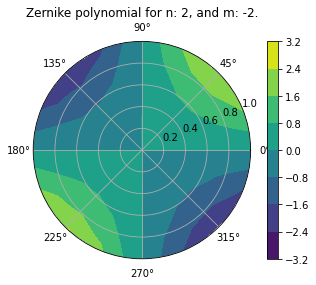

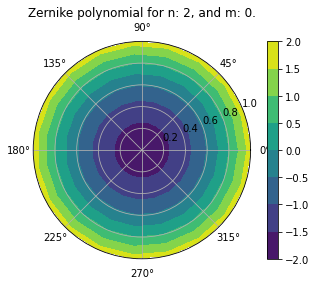

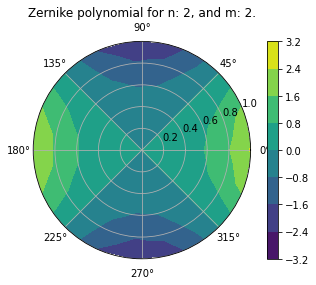

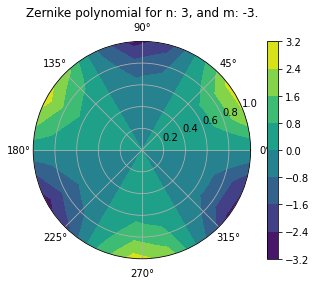

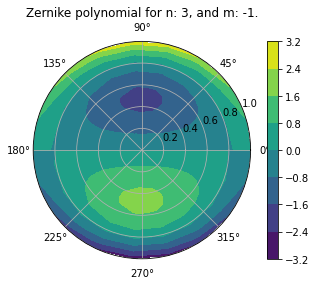

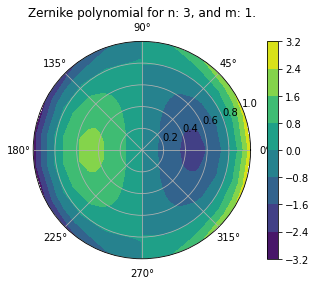

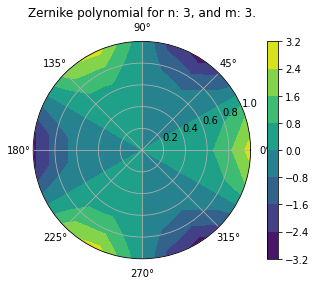

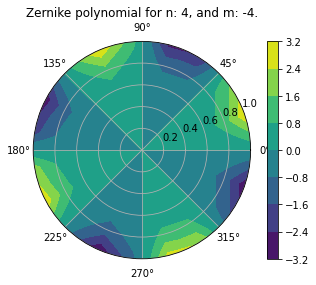

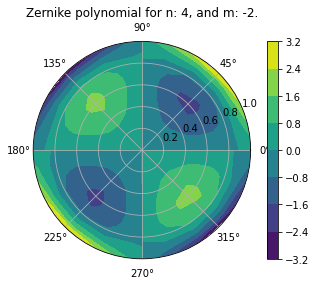

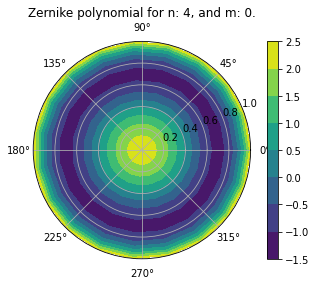

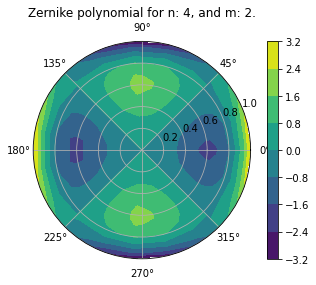

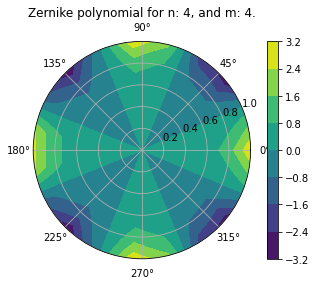

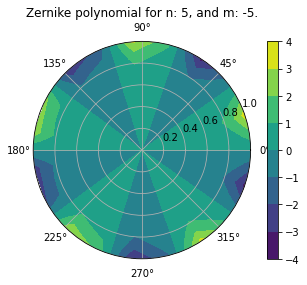

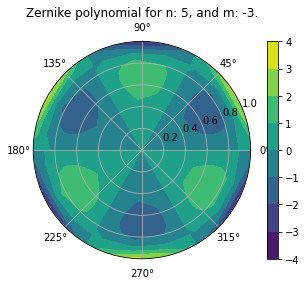

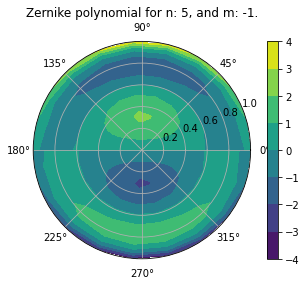

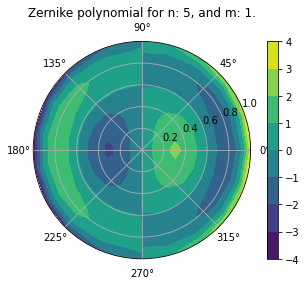

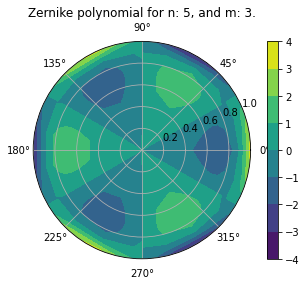

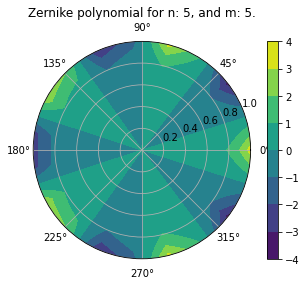

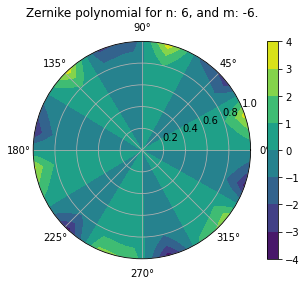

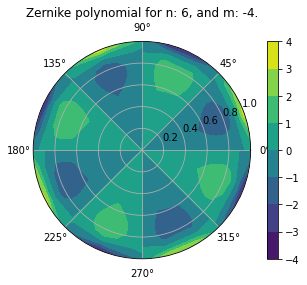

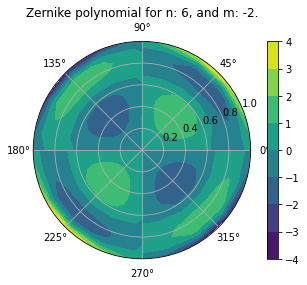

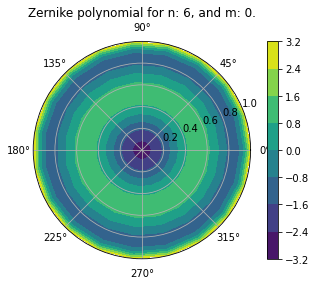

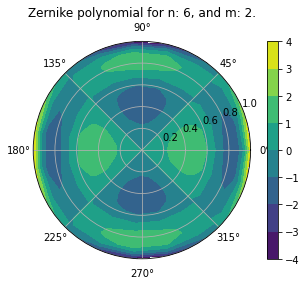

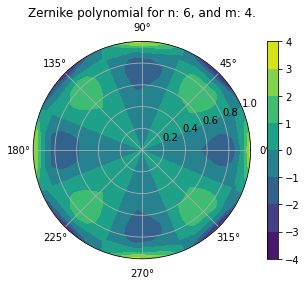

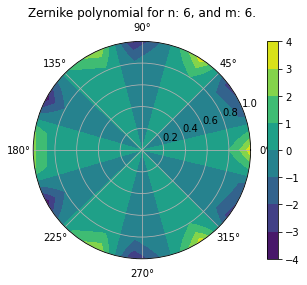

In [27]:
zernike = zernike_polynomial_generator()

# Initialising list of Zernike polynomials
Z = torch.zeros(20,20)
# Initialising list of the pupil radius
P = torch.linspace(0,1,20)
# Initialising list of the Azimuthal angle
Phi = torch.linspace(0,2*math.pi, 20)

#Test coefficients from [Watson, A.B., 2015. Computing human optical point spread functions. Journal of vision, 15(2), pp.26-26.] 
# and [ThibosHongBradleyChengData; Thibos, Hong et al., 2002]

# You can uncomment the following if you wish to view the results from a preset standard list of coefficients

# coefficients = [[2,-2,-0.0946],[2,0,0.0969],[2,2,0.305],[3,-3,0.0459],
# [3,-1,-0.121],[3,1,0.0264],[3,3,-0.113],[4,-4,0.0292],[4,-2,0.03],
# [4,0,0.0294],[4,2,0.0163],[4,4,0.064],[5,-5,0.0499],[5,-3,-0.0252],
# [5,-1,0.00744],[5,1,0.00155],[5,3,-0.00686],[5,5,0.0288],[6,-6,0.00245],
# [6,-4,0.00185],[6,-2,0.00122],[6,0,-0.00755],[6,2,-0.000693],
# [6,4,0.000551],[6,6,-0.0148]]

#Plotting for each set of coefficients:
for coefficient in coefficients:
    n = coefficient[0]
    m = coefficient[1]
    for x, phi in enumerate(Phi):
        for y, p in enumerate(P):
            Z[x,y] = zernike.zernike_polynomial(n, m, p, phi)

    # Code used for plotting:
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    All_Phi, All_P = torch.meshgrid(Phi, P)
    p0 = ax.contourf(All_Phi, All_P, Z)
    cbar = plt.colorbar(p0, ax=ax)
    ax.set_title("Zernike polynomial for n: " + str(n) + ", and m: " + str(m) + ".")
    plt.show()

## Please note certain combinations of n and m for the Zernike Polynomial are not possible, asnd this will show up as completely blue polar plots.

# The following code helps visualise the weighted sum of all the zernike polynomials generated using the user defined coefficients:

C:\Users\adamj\AppData\Local\Temp/ipykernel_30904/3180428506.py:42: DeprecationWarning: Using factorial() with floats is deprecated
  R += (((p**(n-(2*k))))*(((-1)**k))*math.factorial(n-k))/(math.factorial(k)*math.factorial((n+abs(m))/2-k)*math.factorial((n-abs(m))/2-k))


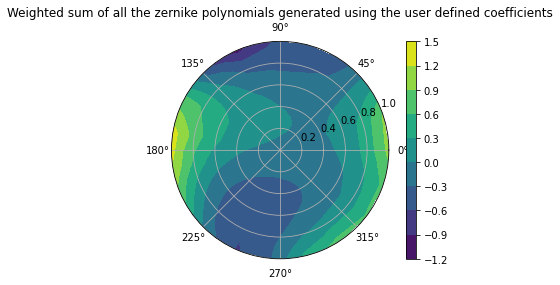

In [28]:
# zernike = zernike_polynomial_generator()

W = torch.zeros(20,20)
P = torch.linspace(0,1,20)
Phi = torch.linspace(0,2*math.pi, 20) #previously from -pi to pi


for x, phi in enumerate(Phi):
    for y, p in enumerate(P):
        W[x,y] = zernike.wavefront_error_function(coefficients, p, phi)


# Code used for plotting:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
All_Phi, All_P = torch.meshgrid(Phi, P)
p0 = ax.contourf(All_Phi, All_P, W)
cbar = plt.colorbar(p0, ax=ax)
ax.set_title("Weighted sum of all the zernike polynomials generated using the user defined coefficients")
plt.show()

## The following code helps visualise the generated point spread function using the user defined coefficients:

C:\Users\adamj\AppData\Local\Temp/ipykernel_30904/3180428506.py:42: DeprecationWarning: Using factorial() with floats is deprecated
  R += (((p**(n-(2*k))))*(((-1)**k))*math.factorial(n-k))/(math.factorial(k)*math.factorial((n+abs(m))/2-k)*math.factorial((n-abs(m))/2-k))


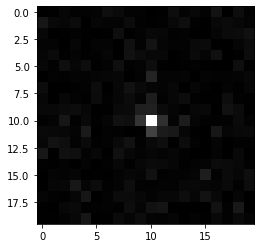

In [29]:
psf = zernike.point_spread_function(coefficients)

plt.imshow(psf,cmap="gray")


## The following code helps visualise the result of the convolution of the point spread function with the defined image:

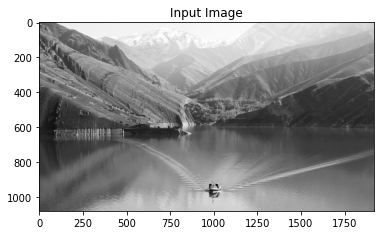

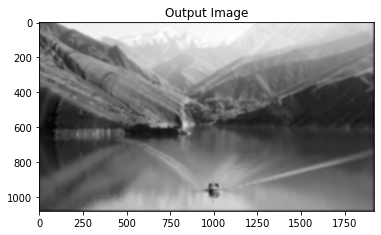

In [30]:
filepath = "./Datasets"
## Image from: https://wordpress.org/openverse/image/f9ab12af-bb96-4aa5-8d44-dea2d1dbf5ab
#images = []
#Looping through each filename that exists within the filepath

for filename in os.listdir(filepath):
    #The full file path for current image:
    filename = os.path.join(filepath, filename)
    # Loading image from the file path as a tensor with shape (1x1xHxW))
    image = load_image(filename)
    # Convolving the input image with the psf to generate the output image
    output_image = forward(image, psf)
    
    # ------------------------------------------------------------------------------------ #

    ## Plotting Input image
    plt.imshow(torch.squeeze(image),cmap='gray')
    plt.title("Input Image")
    plt.show()
    
    ## Plotting Output image
    plt.imshow(torch.squeeze(output_image),cmap='gray')
    plt.title("Output Image")
    plt.show()
    

## 4. Problem and potential solutions (15 points)
<a name='question4'></a>

## Problems associated to Eyebox size with Near Eye Displays (NEDs) for Holography
The source of this study is a paper by Xia, X., et al [1], titled “Towards Eyeglass-style Holographic Near-eye Displays with Statically Expanded Eyebox.”

AR in NEDs has many tradeoffs between providing a large field of view, a wide eyebox, high resolution and correct focal cues, all in a compact form factor at the same time [1][2]. A large eyebox is required because a small eyebox constrains the user from moving their eyes while looking at the display.

A primary feature of NEDs for AR is creating depth perception of objects displayed. Most existing devices cause visual fatigue with prolonged use, and some methods solve this problem but suffer from a limited field of view [3], or a larger form factor.

Xia, X., et al [1] state that holography is the only method available that can offer a wide field of view alongside a compact form factor in NEDs for AR, but the eyebox of current designs are very small. They propose a design with a wide eyebox, expanding from a size of about 1mm to about 10mm. They fabricate a holographic optical element that acts as an image combiner with the enlarged eyebox, using a phase spatial light modulator for shifting the phase of the light projected, thus allowing the images to be perceived at different focal distances, without moving parts [1]. Their results show that the eyebox size can be expanded without a noticeable loss of resolution.

A problem with this design is that it creates multiple focal points in the expanded eyebox, but it does not change image resolution at each focal point, and the image is perceived with only a slight distortion at different focal points. This can be mitigated by utilising traditional optics, but this makes the device less compact. Xia, X., et al [1] mention that they tested the resolution by displaying a 3D wireframe object, which was observed to have a sharp and bright wireframe even when viewing the empty space within the object. They propose to fix this by fabricating a higher-quality Holographic Optical Element which reduces laser speckle of displayed objects.

New solutions in the future could adopt the approach proposed by Kim, J., et al., [2], where the focal depth and resolution of the display dynamically changes by using a Maxwellian-view display with a translating nodal point, which follows the person’s pupil when the eye moves. The tunable lens approach also removes the need for prescription glasses for the user. Gaze tracking is performed by using an infrared camera to capture the person’s eye. Although the design is composed of moving parts, they have shown that making a compact device is feasible. However due to the mechanical complexity of the device, it suffers from low reliability, and further research is required to make these devices feasible to address the aforementioned issues.

## References:
[1] Xia, X., et al., 2020, November. Towards Eyeglass-style Holographic Near-eye Displays with Statically Expanded Eyebox. In 2020 IEEE International Symposium on Mixed and Augmented Reality (ISMAR) (pp. 312-319). IEEE.

[2] Kim, J., et al., 2019. Foveated AR: dynamically-foveated augmented reality display. ACM Transactions on Graphics (TOG), 38(4), pp.1-15.

[3] Chakravarthula, P., et al., 2018. Focusar: Auto-focus augmented reality eyeglasses for both real world and virtual imagery. IEEE transactions on visualization and computer graphics, 24(11), pp.2906-2916.
